# Table of Contents
* [1. Introduction](#section-1)
* [2. Data Cleaning](#section-2)
  * [2.1. Basic Sanity Check](#section-2-1)

<a id="section-1"></a>
## 1. Introduction

- What you did: Describe the steps you took, including data cleaning, feature engineering, modelling, evaluation, etc.
- Why you did it: Justify your decisions—why you chose a particular method, metric, or approach over alternatives.
- What you considered but didn’t do: If you explored or ruled out other options, briefly explain your reasoning.
- What the results mean: Interpret your findings in a way that would be understandable to someone reviewing the notebook without additional context.

* The goal of this task is to predict the risk of offering an insurance policy to a potential customer, based on their personal and financial information. 
* The risk is defined as the probability of the customer filing a claim within a year of purchasing the policy. A higher risk means a higher chance of the customer making a claim, which would result in a loss for the insurance company. 
* Therefore, the insurance company wants to understand the risk profile of each customer to determine the level of risk currently held, and how to price products. 
* The business would also like to understand how we could use this model to ensure that only 5% of the people they sell a policy to would claim on their policy.

- [X] Create a feature for customers who had claims in the last year and evaluate the correlation other features
- [ ] Use SHAP to explain the contribution of each feature to it
- [ ] Something Causal???
- [ ] Establish rules like whenever a policiy have a higher risk, instead of rejecting it, just send to the underwriter to review

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# from ydata_profiling import ProfileReport

pd.set_option('display.max_columns', None)     # show all columns

In [2]:
df = pd.read_csv("generated_synthetic_task_data.csv")

<a id="section-2"></a>
## 2. Exploratory Data Analysis

##### Features related to claims

- [X] claim_reported_date -> Most important - where we will derive our target

##### Features related to customers

- [ ] customer_age
- [ ] customer_education_level
- [ ] customer_occupation_sector
- [ ] customer_email_verified
- [ ] customer_home_ownership
- [ ] customer_credit_one
- [ ] customer_credit_two
- [ ] customer_credit_three
- [ ] customer_salary_band
- [ ] customer_age_scaled
- [ ] customer_gender 
- [ ] additional_customer_flag
- [ ] location_code
- [ ] location_score

##### Features related to the policy

- [ ] policy_renewal_number
- [ ] policy_premium_band
- [ ] policy_type
- [ ] policy_category_two
- [ ] policy_cover_level
- [ ] policy_start_date
- [ ] policy_end_date
- [ ] policy_item_category
- [ ] policy_excess
- [ ] is_joint_policy
- [ ] other_policy_flag
- [ ] market_segment

##### Features related to payment

- [ ] payment_frequency
- [ ] payment_method

---

<a id="section-2-1"></a>
### 2.1. Basic Sanity Check

#### 1.1.1 - Checking for duplicates

In [20]:
# flag all rows where policy_identifier appears more than once
dupes = df[df.duplicated(subset='policy_identifier', keep=False)]

# inspect them
# dupes.sort_values('policy_identifier').head(20)
dupes.shape

(1249, 32)

In [27]:
# Boolean mask for all but the first occurrence of each fully-duplicate row
dup_mask = df.duplicated(keep='first')

# Number of rows that would go away if you dropped full duplicates
n_removed = dup_mask.sum()
print(f"Rows to remove: {n_removed}")

# For reference, total vs. unique
total_rows  = len(df)
unique_rows = len(df.drop_duplicates())
print(f"Total rows: {total_rows}, Unique rows: {unique_rows}")

Rows to remove: 626
Total rows: 59806, Unique rows: 59180


In [22]:
# 1. Remove rows that are full dups across *all* columns
df_unique = df.drop_duplicates()

# 2. Now find any policy_identifier that still appears more than once
mask = df_unique['policy_identifier'].duplicated(keep=False)

# 3. Subset to only those rows
df_conflicts = df_unique[mask].sort_values('policy_identifier')

print(f"Found {df_conflicts['policy_identifier'].nunique()} policy IDs with conflicting rows.")
df_conflicts.head(20)

Found 0 policy IDs with conflicting rows.


,policy_identifier,policy_renewal_number,policy_premium_band,location_code,location_score,market_segment,policy_type,payment_frequency,customer_education_level,customer_occupation_sector,policy_category_two,policy_cover_level,customer_email_verified,payment_method,is_joint_policy,other_policy_flag,policy_excess,customer_home_ownership,customer_credit_one,customer_credit_two,customer_credit_three,customer_salary_band,customer_age,policy_start_date,policy_end_date,claim_reported_date,customer_gender,additional_customer_flag,policy_item_category,claim_duration_days,claims_first_year,claims_first_6mo


In [30]:
# Option A: using groupby + transform
counts = df.groupby('policy_identifier')['policy_identifier'].transform('count')
df_3plus = df[counts >= 3]

print(f"Found {df_3plus['policy_identifier'].nunique()} IDs with ≥3 occurrences, totaling {len(df_3plus)} rows.")

Found 3 IDs with ≥3 occurrences, totaling 9 rows.


In [32]:
df_3plus.sort_values('policy_identifier')

,policy_identifier,policy_renewal_number,policy_premium_band,location_code,location_score,market_segment,policy_type,payment_frequency,customer_education_level,customer_occupation_sector,policy_category_two,policy_cover_level,customer_email_verified,payment_method,is_joint_policy,other_policy_flag,policy_excess,customer_home_ownership,customer_credit_one,customer_credit_two,customer_credit_three,customer_salary_band,customer_age,policy_start_date,policy_end_date,claim_reported_date,customer_gender,additional_customer_flag,policy_item_category,claim_duration_days,claims_first_year,claims_first_6mo
49271,PL_008038,4,0,RL_3,356,Chartreuse,PT_1,Quarterly,A,YJ,J,2,False,Y,No,2,0,NaN,0,118,200,0,53,2022-05-07,2023-05-07,NaT,Male,0,BC,NaN,0,0
58646,PL_008038,4,0,RL_3,356,Chartreuse,PT_1,Quarterly,A,YJ,J,2,False,Y,No,2,0,NaN,0,118,200,0,53,2022-05-07,2023-05-07,NaT,Male,0,BC,NaN,0,0
59104,PL_008038,4,0,RL_3,356,Chartreuse,PT_1,Quarterly,A,YJ,J,2,False,Y,No,2,0,NaN,0,118,200,0,53,2022-05-07,2023-05-07,NaT,Male,0,BC,NaN,0,0
50933,PL_023666,7,0,RL_2,150,Chartreuse,PT_1,Quarterly,NaN,YJ,J,2,False,Y,No,2,0,Rent,0,118,200,0,34,2022-05-07,2023-05-07,2023-04-20,Male,1,AC,348.0,1,0
58788,PL_023666,7,0,RL_2,150,Chartreuse,PT_1,Quarterly,NaN,YJ,J,2,False,Y,No,2,0,Rent,0,118,200,0,34,2022-05-07,2023-05-07,2023-04-20,Male,1,AC,348.0,1,0
59782,PL_023666,7,0,RL_2,150,Chartreuse,PT_1,Quarterly,NaN,YJ,J,2,False,Y,No,2,0,Rent,0,118,200,0,34,2022-05-07,2023-05-07,2023-04-20,Male,1,AC,348.0,1,0
24681,PL_028116,5,0,RL_5,112,Lavendar,PT_4,Annual,NaN,IE,K,6,True,X,Yes,2,1200,Rent,710,936,1000,3,31,2022-05-07,2023-05-07,NaT,Male,0,DB,NaN,0,0
58747,PL_028116,5,0,RL_5,112,Lavendar,PT_4,Annual,NaN,IE,K,6,True,X,Yes,2,1200,Rent,710,936,1000,3,31,2022-05-07,2023-05-07,NaT,Male,0,DB,NaN,0,0
59136,PL_028116,5,0,RL_5,112,Lavendar,PT_4,Annual,NaN,IE,K,6,True,X,Yes,2,1200,Rent,710,936,1000,3,31,2022-05-07,2023-05-07,NaT,Male,0,DB,NaN,0,0


#### 1.1.2 - Checking for NANs

In [34]:
df.customer_education_level.value_counts()

customer_home_ownership
Rent     32117
Other    22930
Own       1157
Name: count, dtype: int64

In [37]:
df.customer_home_ownership.value_counts()

customer_education_level
B    17102
A    14356
D    13409
G     4023
F     2284
I     2010
C     1531
H     1158
E      340
Name: count, dtype: int64

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59806 entries, 0 to 59805
Data columns (total 32 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   policy_identifier           59806 non-null  object        
 1   policy_renewal_number       59806 non-null  int64         
 2   policy_premium_band         59806 non-null  int64         
 3   location_code               59806 non-null  object        
 4   location_score              59806 non-null  int64         
 5   market_segment              59806 non-null  object        
 6   policy_type                 59806 non-null  object        
 7   payment_frequency           59806 non-null  object        
 8   customer_education_level    56213 non-null  object        
 9   customer_occupation_sector  59806 non-null  object        
 10  policy_category_two         59806 non-null  object        
 11  policy_cover_level          59806 non-null  int64     

In [38]:
df.describe()

,policy_renewal_number,policy_premium_band,location_score,policy_cover_level,other_policy_flag,policy_excess,customer_credit_one,customer_credit_two,customer_credit_three,customer_salary_band,customer_age,policy_start_date,policy_end_date,claim_reported_date,additional_customer_flag,claim_duration_days,claims_first_year,claims_first_6mo
count,59806.000000,59806.000000,59806.000000,59806.000000,59806.0,59806.000000,59806.000000,59806.000000,59806.000000,59806.000000,59806.000000,59806,59806,3846,59806.000000,3846.000000,59806.000000,59806.000000
mean,5.661221,1.032338,183.634502,3.136976,2.0,635.242283,336.460773,586.023743,499.314601,1.759004,37.423670,2022-05-07 00:00:00,2023-05-07 00:00:00,2022-11-04 08:57:39.594383872,0.022606,181.373375,0.064308,0.031519
min,0.000000,0.000000,0.000000,1.000000,2.0,0.000000,0.000000,0.000000,0.000000,0.000000,21.000000,2022-05-07 00:00:00,2023-05-07 00:00:00,2022-05-07 00:00:00,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,75.000000,2.000000,2.0,0.000000,0.000000,118.000000,200.000000,0.000000,27.000000,2022-05-07 00:00:00,2023-05-07 00:00:00,2022-08-04 00:00:00,0.000000,89.000000,0.000000,0.000000
50%,5.000000,1.000000,168.000000,2.000000,2.0,700.000000,332.000000,773.000000,424.000000,2.000000,36.000000,2022-05-07 00:00:00,2023-05-07 00:00:00,2022-11-06 00:00:00,0.000000,183.000000,0.000000,0.000000
75%,10.000000,2.000000,262.000000,6.000000,2.0,1200.000000,456.000000,832.000000,686.000000,3.000000,45.000000,2022-05-07 00:00:00,2023-05-07 00:00:00,2023-02-03 00:00:00,0.000000,272.000000,0.000000,0.000000
max,14.000000,20.000000,750.000000,6.000000,2.0,1250.000000,710.000000,999.000000,1000.000000,5.000000,90.000000,2022-05-07 00:00:00,2023-05-07 00:00:00,2023-05-06 00:00:00,1.000000,364.000000,1.000000,1.000000
std,4.170966,1.117235,129.996302,1.832597,0.0,460.275030,258.531542,333.375203,317.444357,1.389208,11.950305,NaN,NaN,NaN,0.148646,105.694057,0.245303,0.174716


In [39]:
df.nunique()

policy_identifier             59180
policy_renewal_number            15
policy_premium_band              13
location_code                    22
location_score                   41
market_segment                    6
policy_type                      11
payment_frequency                 3
customer_education_level          9
customer_occupation_sector        9
policy_category_two              11
policy_cover_level                3
customer_email_verified           2
payment_method                    2
is_joint_policy                   2
other_policy_flag                 1
policy_excess                     5
customer_home_ownership           3
customer_credit_one               9
customer_credit_two              10
customer_credit_three            10
customer_salary_band              5
customer_age                     41
policy_start_date                 1
policy_end_date                   1
claim_reported_date             365
customer_gender                   4
additional_customer_flag    

### 1.2 - Exploring features related to **Claims**
The main objetive is to identify which customers had claims within a year of purchasing the policy and create a feature with a flag for those costumers who had claims during the first year.

What also can be taken into consideration is the fact that since all policies are renewed annually, the record of previous years claims cannot be assessed with this dataset, since this is basically a snapshot for a specific year (2022). If data from previous years were also available, this information could be helpfull to better understand the patterns of the claims, even for long term costumers.

In [3]:
# Identify the typing of the date columns related to the policy
print(type(df["policy_start_date"].iloc[-1]))
print(type(df["policy_end_date"].iloc[-1]))
print(type(df["claim_reported_date"].iloc[-1]))

<class 'str'>
<class 'str'>
<class 'str'>


In [4]:
# Convert the type from str to datetime to get the day count since policy purchase
# The policy_start_date is the same for all customers in the dataset

date_columns = ["policy_start_date", "policy_end_date", "claim_reported_date"]
for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce') #using coerce just to avoid potential errors with NaNs or typos

df['claim_duration_days'] = (df['claim_reported_date'] - df['policy_start_date']).dt.days

In [5]:
# Just a sanity check to guarantee that there are no claims after the policy period
# This could turn out to be a test when using pytest
late_reported_claims = df[df["claim_reported_date"] > df["policy_end_date"]]
num_late_claims = len(late_reported_claims)
print(f"Found {num_late_claims} claims that were reported after the policy end date.")

Found 0 claims that were reported after the policy end date.


#### 1.1.1 - Create feature column with costumers that had claims in the first year -> ** OUR MODEL TARGET**

In [6]:
df['claims_first_year'] = (df['claim_duration_days'] <= 365).astype(int)
df['claims_first_6mo'] = (df['claim_duration_days'] <= 180).astype(int)    
# Just checking how many claims occurred in the first six months. Might use as higher risk groups

In [11]:
df

,policy_identifier,policy_renewal_number,policy_premium_band,customer_age,location_code,location_score,market_segment,policy_type,payment_frequency,customer_education_level,customer_occupation_sector,policy_category_two,policy_cover_level,customer_email_verified,payment_method,is_joint_policy,other_policy_flag,policy_excess,customer_home_ownership,customer_credit_one,customer_credit_two,customer_credit_three,customer_salary_band,customer_age_scaled,policy_start_date,policy_end_date,claim_reported_date,customer_gender,additional_customer_flag,policy_item_category,claim_duration_days,claims_first_year,claims_first_6mo
0,PL_045360,9,1,41,RL_8,112,Lavendar,PT_4,Annual,D,IE,K,6,True,X,Yes,2,1200,Rent,710,936,1000,3,31,2022-05-07,2023-05-07,NaT,Male,0,DD,NaN,0,0
1,PL_016745,8,1,35,RL_2,0,Viridian,PT_9,Annual,I,OW,H,2,False,X,No,2,1250,Other,456,654,0,4,21,2022-05-07,2023-05-07,NaT,Female,0,CC,NaN,0,0
2,PL_007194,9,0,44,RL_8,168,Lavendar,PT_4,Annual,D,IE,K,6,True,X,Yes,2,1200,Rent,710,936,1000,3,36,2022-05-07,2023-05-07,NaT,Male,0,DB,NaN,0,0
3,PL_018146,5,0,44,RL_10,168,Chartreuse,PT_1,Quarterly,A,YJ,J,2,False,Y,No,2,0,Rent,0,118,200,0,36,2022-05-07,2023-05-07,NaT,Male,0,DB,NaN,0,0
4,PL_049011,10,1,56,RL_13,393,Taupe,PT_5,Annual,C,AZ,A,2,False,X,No,2,1200,Other,452,832,656,5,57,2022-05-07,2023-05-07,NaT,Prefer not to say,0,CD,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59801,PL_039704,8,1,40,RL_5,93,Taupe,PT_7,Monthly,B,QV,C,6,True,X,No,2,700,Other,452,802,536,0,29,2022-05-07,2023-05-07,2023-01-04,Male,0,BB,242.0,1,0
59802,PL_019309,11,1,48,RL_5,243,Viridian,PT_9,Annual,I,OW,H,2,False,X,No,2,1250,Other,456,654,0,4,43,2022-05-07,2023-05-07,2023-03-18,Male,0,CA,315.0,1,0
59803,PL_029957,10,1,35,RL_5,0,Taupe,PT_6,Monthly,B,QV,D,2,False,X,No,2,700,Other,332,773,424,2,21,2022-05-07,2023-05-07,2022-06-14,Male,1,BB,38.0,1,1
59804,PL_039457,0,0,42,RL_3,131,Chartreuse,PT_1,Quarterly,A,YJ,J,2,False,Y,No,2,0,Rent,0,118,200,0,33,2022-05-07,2023-05-07,2023-03-14,Male,1,BB,311.0,1,0


### 1.3 - Exploring features related to **Costumers**

#### 1.4 - Evaluation of anomaly with customer_age columns

It has been noticed the presence of two customer ages (customer_age and customer_age_scaled) and that the histograms show almost the same distribution, differing in the max and min values, indicating a linear transformation on the data
The correlation between them was checked and shown a coefficient of 0.999
It might be an anomaly, an error, or the slope and intercept have a meaning to the business that I have not had access so far
In this study we will consider the column **costumer_age_scaled** as the correct data, ranging from 21 to 90, with the following changes:
- The column **costumer_age** will be droped
- The column **costumer_age_scaled** will be renamed to **costumer_age**

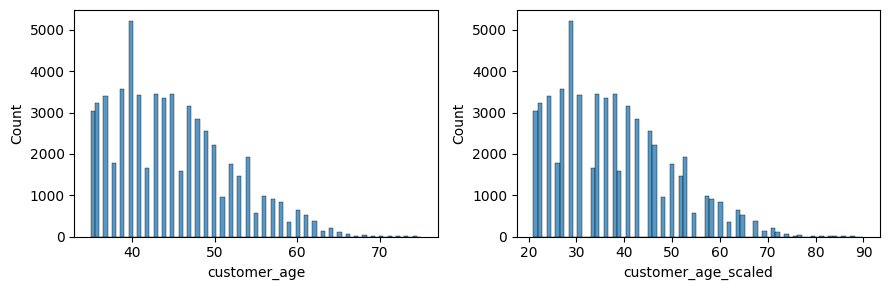

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3))
sns.histplot(data=df, x='customer_age', kde=False, ax=axes[0])
sns.histplot(data=df, x='customer_age_scaled', kde=False, ax=axes[1])
plt.tight_layout()
plt.show()

In [13]:
corr = df['customer_age'].corr(df['customer_age_scaled'])
slope, intercept = np.polyfit(df['customer_age_scaled'], df['customer_age'], 1)
print('corr:', corr, 'slope,intercept:', slope, intercept)

corr: 0.9997190876858193 slope,intercept: 0.5800474162638276 23.107967006904772


In [14]:
print(f'customer_age = customer_age_scaled * 0.58 + 23.10 -> (example) 90 * 0.58 + 23.10 = {round(90 * 0.5800474162638276 + 23.107967006904772, 0)}')

customer_age = customer_age_scaled * 0.58 + 23.10 -> (example) 90 * 0.58 + 23.10 = 75.0


In [16]:
display(df[['customer_age', 'customer_age_scaled']].head(3))
# display(df[['customer_age', 'customer_age_scaled']].tail(3))

,customer_age,customer_age_scaled
0,41,31
1,35,21
2,44,36


In [17]:
df = (df.drop(columns='customer_age').rename(columns={'customer_age_scaled': 'customer_age'}))

0.25    27.0
0.50    36.0
0.75    45.0
1.00    90.0
Name: customer_age, dtype: float64



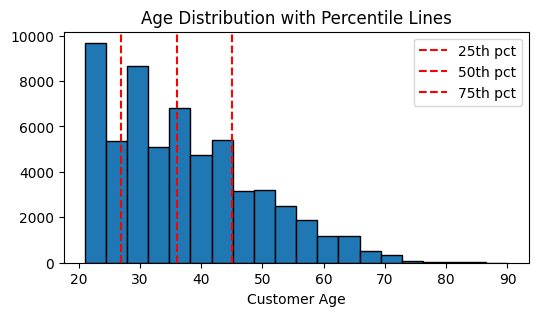

In [18]:
percentiles = df['customer_age'].quantile([0.25, 0.5, 0.75, 1])
print(percentiles)
print()
q25, q50, q75 = df['customer_age'].quantile([0.25, 0.5, 0.75])

plt.figure(figsize=(6,3))
plt.hist(df['customer_age'], bins=20, edgecolor='black')

for pct, q in zip([25, 50, 75], [q25, q50, q75]):
    plt.axvline(q, linestyle='--', label=f'{pct}th pct', color="r")

plt.legend()
plt.xlabel('Customer Age')
plt.title('Age Distribution with Percentile Lines')
plt.show()

### 1.4 Exploring features related to policy

#### 1.5 - Evaluation of Policy Renewals and Policy Premium Bands

When observing the policy renewal number histogram it is clear that there is specific group of loyal costumers that holds a substantial share of policies
On the other hand there are a lot of costumers with a fairly new relationship with the company. So I would take a closer look in these groups to check if there are any peculiarities such: the higher claims in within a year realy come from new costumers?

In [ ]:
df['policy_renewal_number'].value_counts(ascending=False)

In [ ]:
df['policy_premium_band'].value_counts(ascending=False)

In [ ]:
percentile = df['policy_renewal_number'].quantile([0.25, 0.5, 0.75])
print(percentile)
q25, q50, q75 = df['policy_renewal_number'].quantile([0.25, 0.5, 0.75])

plt.figure(figsize=(6,3))
plt.hist(df['policy_renewal_number'], bins=20, edgecolor='black')

for pct, q in zip([25, 50, 75], [q25, q50, q75]):
    plt.axvline(q, linestyle='--', label=f'{pct}th pct', color="r")

plt.legend(loc="upper right")
plt.xlabel('Customer Age')
plt.title('Age Distribution with Percentile Lines')
plt.show()

The correlation coeficient between the policy_renewal_band and the flag for customers have shown that there are no indication of relationship between these two, and the same could be said by the policy_premium_band, so we evaluate the isolated effect of both variables against the claim flag.

What also can be taken into consideration is the fact that since all policies are renewed annually, the record of previous claims cannot be assessed with this dataset, since this is basically a snapshot for a year. If data from previous years were also available, this information could be helpfull to better understand the patterns of the claims, even for long term costumers.

At this stage, another feature will be created considering the 4 different groups of costumers: 
- **bronze** < 2years
- 2years <= **silver** < 5years
- 5years <= **gold** < 10years
- **platinum** >= 10years

These features will later on go through a process called one-hot encoding, which basically creates new columns where for a specific category that costumer have it will receive a flag 1, whilst the other categories which that customer does not belong receives a flag 0

In [ ]:
bins = [0, 2, 5, 10, np.inf]
labels = ['bronze', 'silver', 'gold', 'platinum']

df['renewal_tier'] = pd.cut(df['policy_renewal_number'], bins=bins,
                            labels=labels, right=False, include_lowest=True)
dummies_rt = pd.get_dummies(df['renewal_tier'], prefix='tier', prefix_sep='_', dtype=int)
df = pd.concat([df, dummies_rt], axis=1)

This step does not mean that a clustering analysis couldn't be performed to identify groups. What sometimes can also happen is that some business areas have their own segmentation of clients, and not necessarily are adopted for the whole company. Nevertheless, this sort of information could be very useful since they are generated (even if is with hard rules) by a team of experts that need this sort of information (marketing, pricing, etc.)

I am also supposing that the market_segment feature corresponds to the type of product that the costumer 

In [ ]:
df['premium_band'] = np.where(df['policy_premium_band'].isin([0, 1, 2, 3]),
    df['policy_premium_band'].astype(str), 4)
dummies_pb = pd.get_dummies(df['premium_band'], prefix='premium_band', prefix_sep='_', dtype=int)
df = pd.concat([df, dummies_pb], axis=1)

In [ ]:
corr = pd.concat([dummies_rt, dummies_pb, df['claims_first_year']], axis=1).corr()

sns.heatmap(corr, annot=True, fmt=".2f", cbar_kws={'shrink': 0.5})
plt.xticks(rotation=45, ha='right')

plt.title('Correlation matrix - Policy renewal and premium bands with claims flag')
plt.tight_layout()
plt.show()

#### 1.6 - Evaluation of location features

Since there are a lot of location codes and location scores, I will perform the one hot encoding on them to use them during training.

In [ ]:
df.location_code.value_counts()

In [ ]:
df.location_score.value_counts()

In [ ]:
# Removed the RL_ text from the records in order to perform one hot encoding
df['location_code'] = df['location_code'].astype(str).str.replace(r'^RL_', '', regex=True)

In [ ]:
dummies_lc = pd.get_dummies(df['location_code'], prefix='loc_code', prefix_sep='_', dtype=int)
df = pd.concat([df, dummies_lc], axis=1)

dummies_ls = pd.get_dummies(df['location_score'], prefix='loc_score', prefix_sep='_', dtype=int)
df = pd.concat([df, dummies_ls], axis=1)

corr = pd.concat([dummies_lc, dummies_ls, df['claims_first_year']], axis=1).corr()

# plt.figure(figsize=(9, 3))
sns.heatmap(corr)
plt.xticks(rotation=45, ha='right')

plt.title('Correlation between location code and location score')
plt.tight_layout()
plt.show()

In [ ]:
df.head()

In [ ]:
df['email_verified_flag'] = df['customer_email_verified'].astype(int)
df['joint_policy_flag']  = df['is_joint_policy'].map({'Yes':1, 'No':0})

In [ ]:
corr = df[["email_verified_flag", "joint_policy_flag", "claims_first_year"]].corr()

plt.figure(figsize=(9, 3))
ax = sns.heatmap(corr, annot=True, fmt=".2f", cbar_kws={'shrink': 0.5})

# plt.title('Correlation matrix - Policy renewal and premium bands with claims flag')
plt.tight_layout()
plt.show()

In [ ]:
df.policy_type.value_counts()

In [ ]:
df_num

In [ ]:
# sample data
df = pd.DataFrame({
    'age': [25, 32, 47, 51],
    'income': [50000, 64000, 83000, 91000],
    'fruit': ['apple', 'banana', 'apple', 'cherry']
})

# one-hot encode
dummies = pd.get_dummies(df['fruit'], prefix='fruit')
df_num = pd.concat([df[['age','income']], dummies], axis=1)

# compute & plot
corr = df_num.corr()
sns.heatmap(corr, annot=True, fmt=".2f")
plt.show()

In [ ]:
df_num

In [ ]:
df.describe()

In [ ]:
plt.hist(df['customer_age'], alpha=0.5, bins=20, label='raw')
plt.hist(df['customer_age_scaled'], alpha=0.5, bins=20, label='scaled')
plt.legend()
plt.show()

In [ ]:
profile = ProfileReport(df, title="EDA Report")

In [ ]:
profile.to_file("output_report.html")

## 2 - Feature 